In [1]:
from __future__ import print_function
%matplotlib inline
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas as pd
import pandas_profiling
plt.style.use("ggplot")
warnings.simplefilter("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
plt.rcParams["figure.figsize"] = (12, 8)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
os.chdir('/content/drive/My Drive/Decision-Trees-and-Random-Forests')

In [5]:
hr = pd.read_csv('data/employee_data.csv')
hr_orig = hr
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [6]:
pip install pandas-profiling==2.8.0

In [7]:
hr.profile_report(title = "Data")

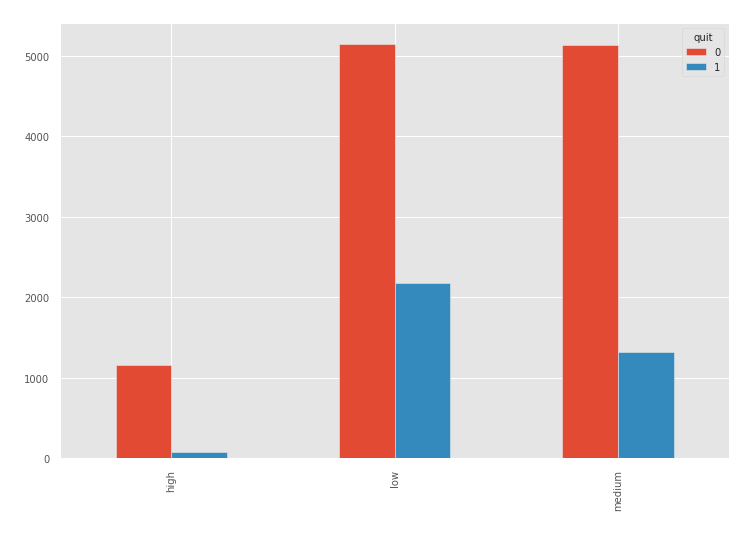

In [8]:
pd.crosstab(hr.salary,hr.quit).plot(kind='bar')
plt.title('Turnover Frequency on Salary Bracket', color = 'w')
plt.xlabel('Salary', color = 'w' )
plt.ylabel('Frequency of Turnover', color = 'w')
plt.show()

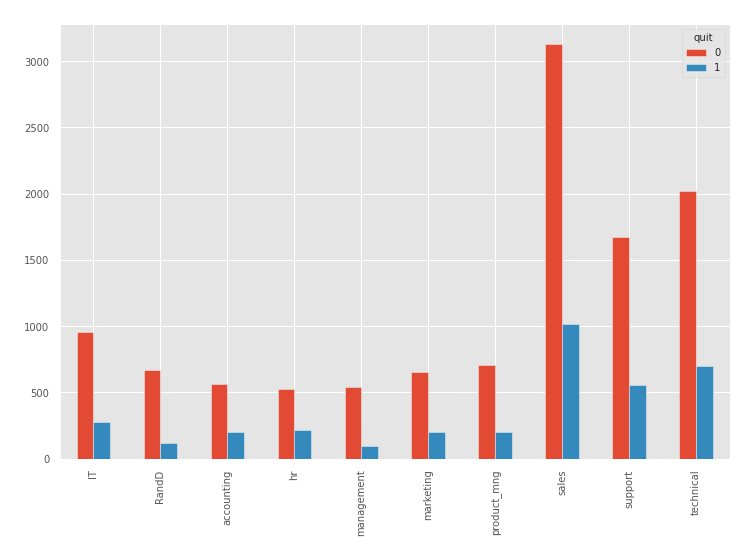

In [9]:
pd.crosstab(hr.department ,hr.quit).plot(kind='bar')
plt.title('Turnover Frequency on Salary Bracket', color = 'w')
plt.xlabel('Salary', color = 'w' )
plt.ylabel('Frequency of Turnover', color = 'w')
plt.show()

In [0]:
cat_vars = ['department', 'salary']

for var in cat_vars:
  cat_list = pd.get_dummies(hr[var], prefix = var)
  hr = hr.join(cat_list)

In [11]:
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,sales,low,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,sales,medium,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,sales,low,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,sales,low,0,0,0,0,0,0,0,1,0,0,0,1,0


In [0]:
hr.drop(columns = ['department', 'salary'], axis = 1, inplace = True)

In [0]:
from yellowbrick.target import ClassBalance
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12,8)

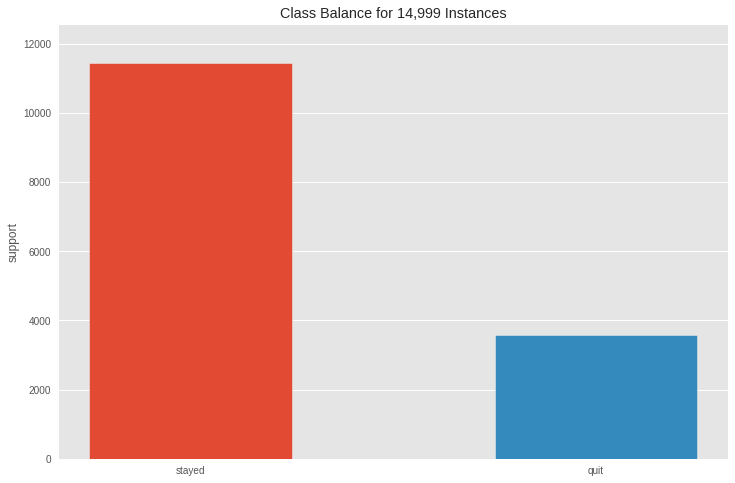

In [14]:
visualizer = ClassBalance(labels = ['stayed', 'quit']).fit(hr.quit)
visualizer.show()

In [0]:
X = hr.loc[:, hr.columns != 'quit']
y = hr.quit

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,
                                                    stratify=y)

In [0]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz # display the tree within a Jupyter notebook
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive, IntSlider, FloatSlider, interact
import ipywidgets
from IPython.display import Image
from subprocess import call
import matplotlib.image as mpimg

In [18]:
@interact
def plot_tree(crit=["gini", "entropy"],
              split=["best", "random"],
              depth=IntSlider(min=1,max=30,value=2, continuous_update=False),
              min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
              min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    
    estimator = DecisionTreeClassifier(random_state=0,
                                       criterion=crit,
                                       splitter = split,
                                       max_depth = depth,
                                       min_samples_split=min_split,
                                       min_samples_leaf=min_leaf)
    estimator.fit(X_train, y_train)
    print('Decision Tree Training Accuracy: {:.3f}'.format(accuracy_score(y_train, estimator.predict(X_train))))
    print('Decision Tree Test Accuracy: {:.3f}'.format(accuracy_score(y_test, estimator.predict(X_test))))

    graph = Source(tree.export_graphviz(estimator,
                                        out_file=None,
                                        feature_names=X_train.columns,
                                        class_names=['0', '1'],
                                        filled = True))
    
    display(Image(data=graph.pipe(format='png')))
    
    return estimator


interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

In [19]:
@interact
def plot_tree_rf(crit=["gini", "entropy"],
                 bootstrap=["True", "False"],
                 depth=IntSlider(min=1,max=30,value=3, continuous_update=False),
                 forests=IntSlider(min=1,max=200,value=100,continuous_update=False),
                 min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
                 min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    
    estimator = RandomForestClassifier(random_state=1,
                                       criterion=crit,
                                       bootstrap=bootstrap,
                                       n_estimators=forests,
                                       max_depth=depth,
                                       min_samples_split=min_split,
                                       min_samples_leaf=min_leaf,
                                       n_jobs=-1,
                                      verbose=False).fit(X_train, y_train)

    print('Random Forest Training Accuracy: {:.3f}'.format(accuracy_score(y_train, estimator.predict(X_train))))
    print('Random Forest Test Accuracy: {:.3f}'.format(accuracy_score(y_test, estimator.predict(X_test))))
    num_tree = estimator.estimators_[0]
    print('\nVisualizing Decision Tree:', 0)
    
    graph = Source(tree.export_graphviz(num_tree,
                                        out_file=None,
                                        feature_names=X_train.columns,
                                        class_names=['0', '1'],
                                        filled = True))
    
    display(Image(data=graph.pipe(format='png')))
    
    return estimator

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

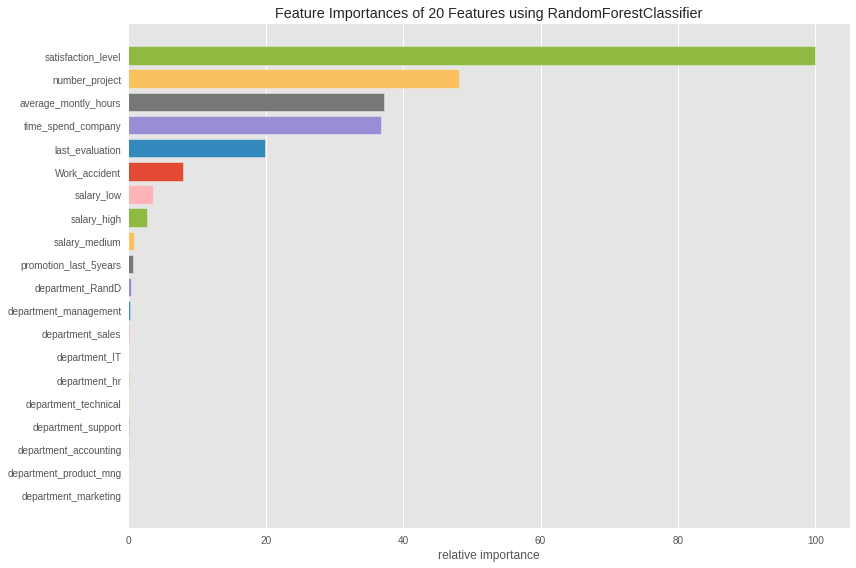

In [20]:
from yellowbrick.model_selection import FeatureImportances
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")

rf = RandomForestClassifier(bootstrap='True', class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=False,
            warm_start=False)

viz = FeatureImportances(rf)
viz.fit(X_train, y_train)
viz.show();

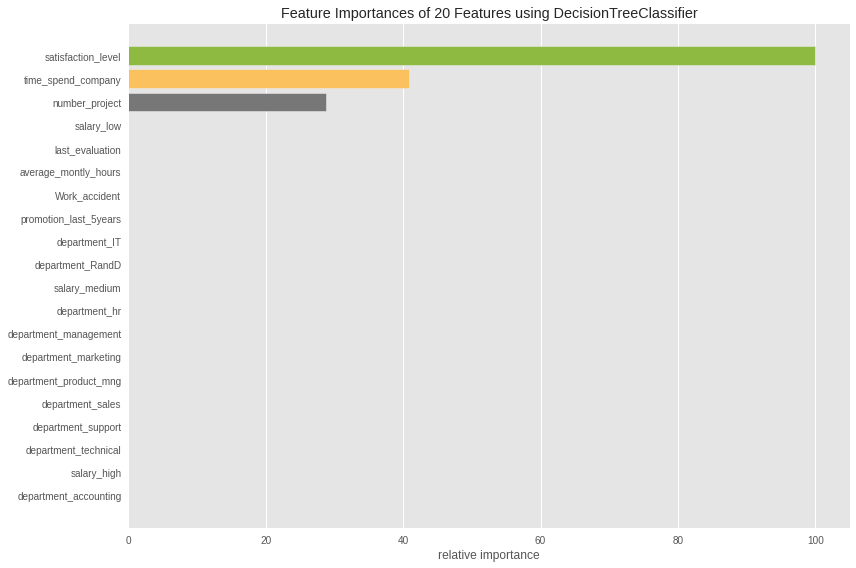

In [23]:
from yellowbrick.model_selection import FeatureImportances
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")

dt = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

viz = FeatureImportances(dt)
viz.fit(X_train, y_train)
viz.show();

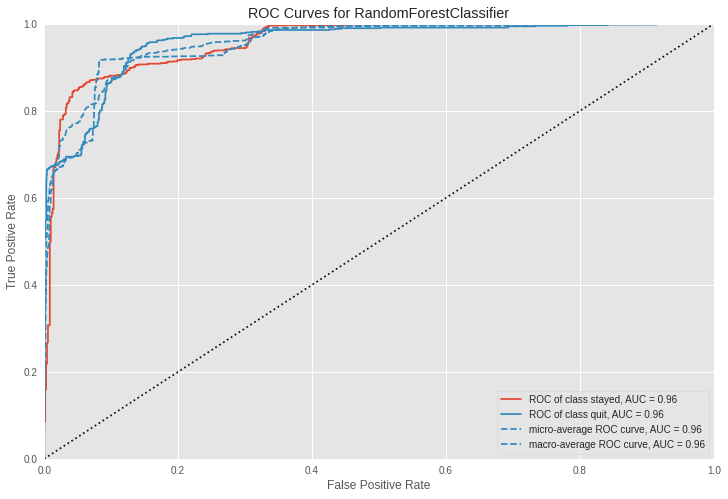

In [21]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(rf, classes=["stayed", "quit"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();

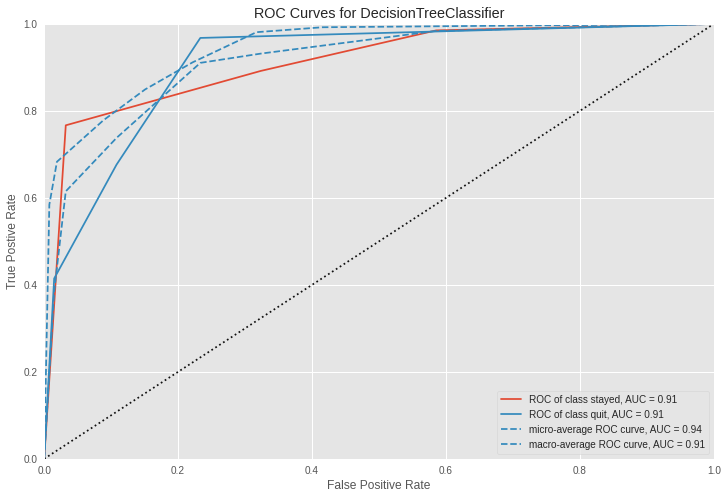

In [22]:
dt = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

visualizer = ROCAUC(dt, classes=["stayed", "quit"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();